In [1]:
import os
import sys

In [2]:
sys.path.append('../lib')

In [3]:
import gen_processes;
import ast

In [4]:
from importlib import reload
reload(gen_processes);

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_default_dtype(torch.double)

In [6]:
from tqdm import tqdm

In [7]:
from itertools import product

In [8]:
import matplotlib.pyplot as plt

In [9]:
import esig

In [10]:
esig.set_backend("iisignature")

In [11]:
RNG = np.random.default_rng(1234)

In [12]:
very_long_processes = gen_processes.gen_ar_iid_samples_burn_in(1001, 20, 0).numpy()
long_processes = gen_processes.gen_ar_iid_samples_burn_in(501, 20, 0).numpy()
medium_processes = gen_processes.gen_ar_iid_samples_burn_in(101, 20, 0).numpy()
short_processes = gen_processes.gen_ar_iid_samples_burn_in(51, 20, 0).numpy()
shorter_processes = gen_processes.gen_ar_iid_samples_burn_in(31, 20, 0).numpy()
nice_processes = gen_processes.gen_ar_iid_samples_burn_in(6, 20, 0.8).numpy()

In [13]:
very_long_processes_ll = np.dstack((very_long_processes[:, 1:, 0], very_long_processes[:, :1000, 0]))
long_processes_ll = np.dstack((long_processes[:, 1:, 0], long_processes[:, :500, 0]))
medium_processes_ll = np.dstack((medium_processes[:, 1:, 0], medium_processes[:, :100, 0]))
short_processes_ll = np.dstack((short_processes[:, 1:, 0], short_processes[:, :50, 0]))
shorter_processes_ll = np.dstack((shorter_processes[:, 1:, 0], shorter_processes[:, :30, 0]))

nice_processes_ll = np.dstack((nice_processes[:, 1:, 0], nice_processes[:, :5, 0]))

In [14]:
sig_vl = esig.stream2sig(very_long_processes_ll[0, :, :].reshape(1000, 2)/8, 10)
sig_l = esig.stream2sig(long_processes_ll[0, :, :].reshape(500, 2)/8, 10)
sig_m = esig.stream2sig(medium_processes_ll[0, :, :].reshape(100, 2)/8, 10)
sig_s = esig.stream2sig(short_processes_ll[0, :, :].reshape(50, 2)/8, 10)
#sig_n = esig.stream2sig(nice_processes_ll[0, :, :].reshape(15, 2)/8, 10)


In [15]:
from esig import tosig
from scipy.optimize import brentq

In [16]:
def get_keys(dim, order):
    s = tosig.sigkeys(dim, order)

    tuples = []

    for t in s.split():
        if len(t) > 2:
            t = t.replace(")", ",)")

        tuples.append(ast.literal_eval(t))

    return tuples

def f(z, a):
    lol = [z ** (2 * m) for m in range(len(a))]
    out = np.dot(a, lol)
    return out

def phi(x, order):
    x = np.array(x)

    a = x ** 2
    a[0] -= psi(norm(x))

    return brentq(lambda z: f(z, a), 0, 1)

def psi(x, M=4, a=1):
    x = x ** 2

    if x <= M:
        return x

    return M + M ** (1 + a) * (M ** (-a) - x ** (-a)) / a

def norm(x):
    return np.linalg.norm(x)

def normalize_sig(sig, order, cheatnum = None):
    keys = get_keys(2, order)

    if cheatnum is None:
        phi_x = phi(tuple(sig), order)
        print(phi_x)
    else:
        phi_x = cheatnum    

    Lambda = np.array([phi_x ** len(t) for t in keys])
    
    return Lambda * sig


In [17]:
this_slice  = RNG.integers(0, 19)


In [18]:
NLEN = 15
nice_processes = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(NLEN+1, 20, a = 0.2, extinction_rate = 1)
nice_processes_x_ll = np.dstack((nice_processes[:, 1:, 0], nice_processes[:, :NLEN, 0]))
nice_processes_y_ll = np.dstack((nice_processes[:, 1:, 1], nice_processes[:, :NLEN, 1]))

In [19]:
def get_lead_lag_proc_length(proc):
    return np.sqrt(np.diff(proc[0])**2 + np.diff(proc[1])**2).sum()

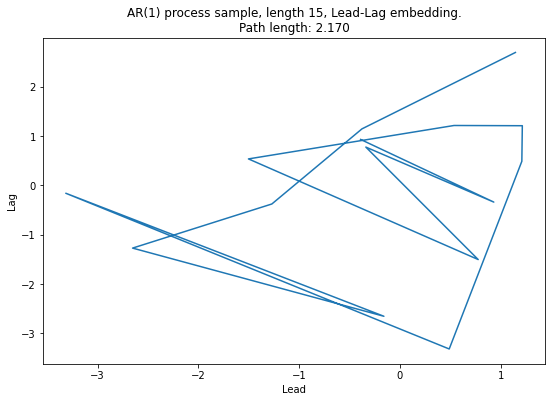

In [20]:
plt.figure(figsize=(9,6))
plt.plot(nice_processes_x_ll[this_slice, :, 0].reshape(NLEN), nice_processes_x_ll[this_slice, :,1].reshape(NLEN))
plt.xlabel('Lead')
plt.ylabel('Lag')
plt.title("AR(1) process sample, length 15, Lead-Lag embedding.\nPath length: {:.3f}".format(get_lead_lag_proc_length(nice_processes_x_ll[this_slice, :].reshape(NLEN, -1))))
plt.savefig('./pics/sig_mistery_ar1_ll_embedding.png')

In [150]:
%matplotlib notebook

In [32]:
gbm_dist_1_samples, gbm_dist_1_samples_id = gen_processes.generate_gbm_iid_samples(0, 3, 0.3, n_paths = 20, m_time_points = NLEN)


In [37]:

#plt.plot(nice_processes_x_ll[this_slice, :, 0].reshape(NLEN), nice_processes_x_ll[this_slice, :,1].reshape(NLEN))
#plt.plot(nice_processes_y_ll[this_slice, :, 0].reshape(NLEN), nice_processes_y_ll[this_slice, :,1].reshape(NLEN))
#plt.figure()
#plt.plot(nice_processes_x_ll[this_slice, :, 0].reshape(NLEN))
#plt.plot(nice_processes_y_ll[this_slice, :, 0].reshape(NLEN))


plt.figure()
sig_n_x_norm = esig.stream2sig(normalize_sig(gbm_dist_1_samples[this_slice, :, :].numpy().reshape(NLEN, 2)*2, 16), 16)#/np.log(tv), 20)
sig_n_x = esig.stream2sig(normalize_sig(gbm_dist_1_samples[this_slice, :, :].numpy().reshape(NLEN, 2)*10, 16), 16)#/np.log(tv), 20)
#sig_n_x = esig.stream2sig(nice_processes_x_ll[this_slice, :, :].reshape(NLEN, 2)/8, 5)#/np.log(tv), 20)
#sig_n_x = esig.stream2sig(nice_processes_x_ll[this_slice, :, :].reshape(NLEN, 2), 16)#/np.log(tv), 20)
#sig_n_y = esig.stream2sig(nice_processes_y_ll[this_slice, :, :].reshape(NLEN, 2), 20)#/np.log(tv), 20)
plt.plot(sig_n_x, alpha = 0.8)
plt.xscale('log', base = 2)
plt.ylabel('Magnitude')
plt.xlabel('Signature term index')
plt.figure()
plt.plot(sig_n_x_norm, alpha = 0.8)

#plt.plot(sig_n_y, alpha = 0.8)
plt.xscale('log', base = 2)
plt.ylabel('Magnitude')
plt.xlabel('Signature term index')
plt.title("Signature of an AR(1) process sample - 15 timesteps\nPath length: {:.3f}".format(get_lead_lag_proc_length(nice_processes_x_ll[this_slice, :].reshape(NLEN, -1))))
plt.savefig('./pics/sig_mistery_ar1_signature_unscaled.png')
#for i in range (20):
    #plt.axvline(2**i, color = 'red')

ValueError: shapes (15,2) and (15,) not aligned: 2 (dim 1) != 15 (dim 0)

<Figure size 432x288 with 0 Axes>

In [ ]:

#plt.plot(nice_processes_x_ll[this_slice, :, 0].reshape(NLEN), nice_processes_x_ll[this_slice, :,1].reshape(NLEN))
#plt.plot(nice_processes_y_ll[this_slice, :, 0].reshape(NLEN), nice_processes_y_ll[this_slice, :,1].reshape(NLEN))
#plt.figure()
#plt.plot(nice_processes_x_ll[this_slice, :, 0].reshape(NLEN))
#plt.plot(nice_processes_y_ll[this_slice, :, 0].reshape(NLEN))

plt.figure(figsize=(9,6))
sig_n_x_norm = normalize_sig(esig.stream2sig(nice_processes_x_ll[this_slice, :, :].reshape(NLEN, 2)/2.2, 5), 5)#/np.log(tv), 20)
sig_n_x = esig.stream2sig(nice_processes_x_ll[this_slice, :, :].reshape(NLEN, 2)/2.2, 5)#/np.log(tv), 20)
plt.plot(sig_n_x, alpha = 0.8)
plt.plot(sig_n_x_norm, alpha = 0.8)

#plt.plot(sig_n_y, alpha = 0.8)
plt.xscale('log', base = 2)
plt.ylabel('Magnitude')
plt.xlabel('Signature term index')
plt.title("Signature of an AR(1) process sample - 15 timesteps.\nPath length: {:.3f}".format(get_lead_lag_proc_length(nice_processes_x_ll[this_slice, :].reshape(NLEN, -1)/2.2)))
plt.savefig('./pics/sig_mistery_ar1_signature_scaled_div_1p5.png')

#for i in range (20):
    #plt.axvline(2**i, color = 'red')

<IPython.core.display.Javascript object>


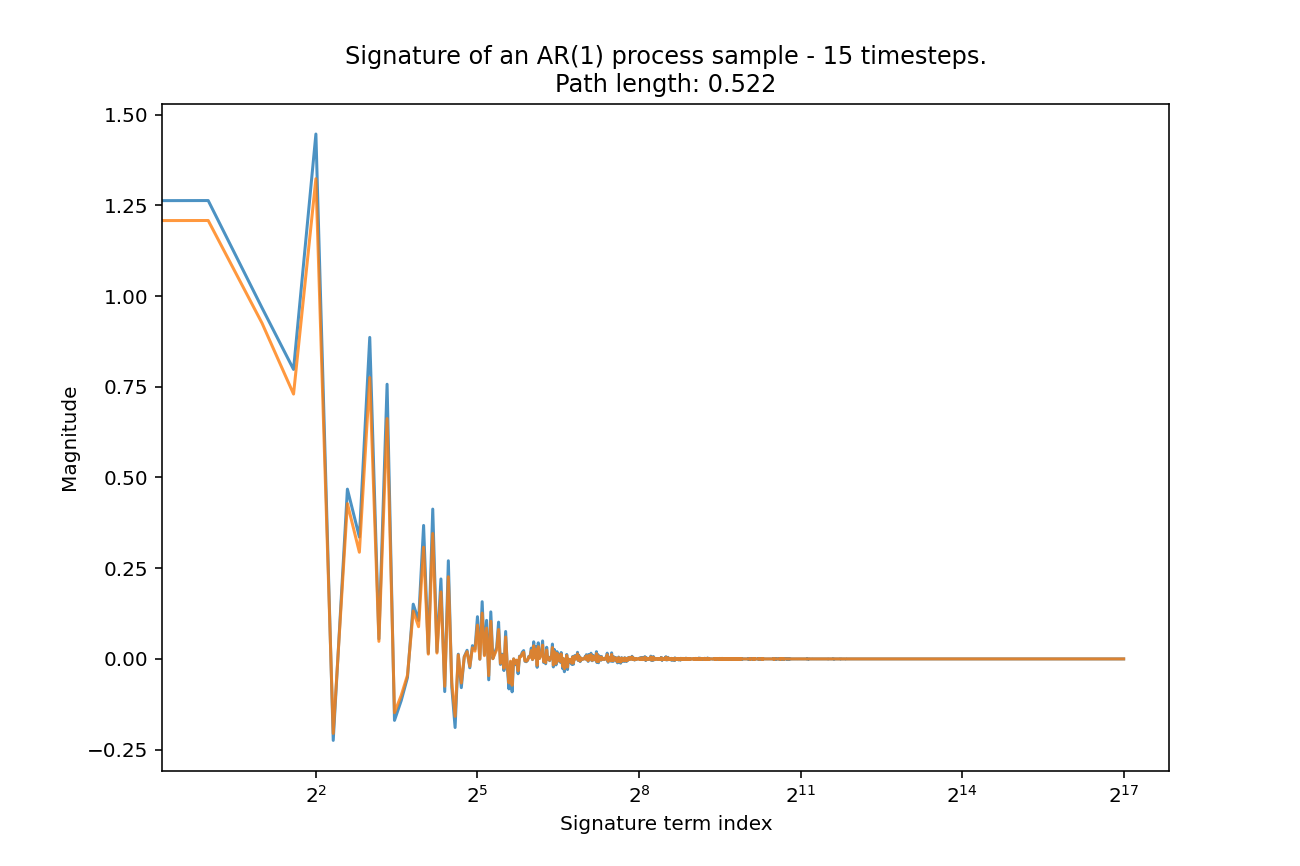

0.9564769791522627


In [141]:

#plt.plot(nice_processes_x_ll[this_slice, :, 0].reshape(NLEN), nice_processes_x_ll[this_slice, :,1].reshape(NLEN))
#plt.plot(nice_processes_y_ll[this_slice, :, 0].reshape(NLEN), nice_processes_y_ll[this_slice, :,1].reshape(NLEN))
#plt.figure()
#plt.plot(nice_processes_x_ll[this_slice, :, 0].reshape(NLEN))
#plt.plot(nice_processes_y_ll[this_slice, :, 0].reshape(NLEN))

plt.figure(figsize=(9,6))
sig_n_x_norm = normalize_sig(esig.stream2sig(nice_processes_x_ll[this_slice, :, :].reshape(NLEN, 2)/4, 16), 16)#/np.log(tv), 20)
sig_n_x = esig.stream2sig(nice_processes_x_ll[this_slice, :, :].reshape(NLEN, 2)/4, 16)#/np.log(tv), 20)
#sig_n_y = esig.stream2sig(nice_processes_y_ll[this_slice, :, :].reshape(NLEN, 2), 20)#/np.log(tv), 20)
plt.plot(sig_n_x, alpha = 0.8)
plt.plot(sig_n_x_norm, alpha = 0.8)

#plt.plot(sig_n_y, alpha = 0.8)
plt.xscale('log', base = 2)
plt.ylabel('Magnitude')
plt.xlabel('Signature term index')
plt.title("Signature of an AR(1) process sample - 15 timesteps.\nPath length: {:.3f}".format(get_lead_lag_proc_length(nice_processes_x_ll[this_slice, :].reshape(NLEN, -1)/4)))
plt.savefig('./pics/sig_mistery_ar1_signature_scaled_div_4.png')

#for i in range (20):
    #plt.axvline(2**i, color = 'red')

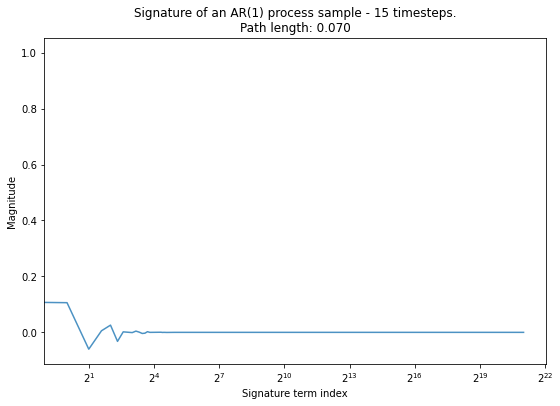

In [35]:

#plt.plot(nice_processes_x_ll[this_slice, :, 0].reshape(NLEN), nice_processes_x_ll[this_slice, :,1].reshape(NLEN))
#plt.plot(nice_processes_y_ll[this_slice, :, 0].reshape(NLEN), nice_processes_y_ll[this_slice, :,1].reshape(NLEN))
#plt.figure()
#plt.plot(nice_processes_x_ll[this_slice, :, 0].reshape(NLEN))
#plt.plot(nice_processes_y_ll[this_slice, :, 0].reshape(NLEN))

plt.figure(figsize=(9,6))
sig_n_x = esig.stream2sig(nice_processes_x_ll[this_slice, :, :].reshape(NLEN, 2)/16, 20)#/np.log(tv), 20)
#sig_n_y = esig.stream2sig(nice_processes_y_ll[this_slice, :, :].reshape(NLEN, 2), 20)#/np.log(tv), 20)
plt.plot(sig_n_x, alpha = 0.8)
#plt.plot(sig_n_y, alpha = 0.8)
plt.xscale('log', base = 2)
plt.ylabel('Magnitude')
plt.xlabel('Signature term index')
plt.title("Signature of an AR(1) process sample - 15 timesteps.\nPath length: {:.3f}".format(get_lead_lag_proc_length(nice_processes_x_ll[this_slice, :].reshape(NLEN, -1)/16)))
plt.savefig('./pics/sig_mistery_ar1_signature_scaled_div_16.png')

#for i in range (20):
    #plt.axvline(2**i, color = 'red')

In [347]:
sig_s = esig.stream2sig(short_processes_ll[0, :, :].reshape(50, 2)/4, 20)

In [50]:
sig_ser = esig.stream2sig(shorter_processes_ll[0, :, :].reshape(30, 2)/4, 20)

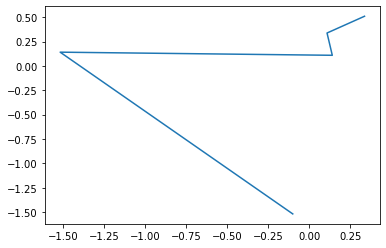

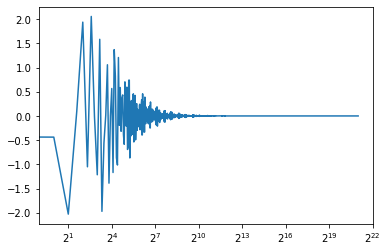

In [231]:
#plt.plot(sig_s)
this_slice  = RNG.integers(0, 19)
#print(nice_processes_ll[this_slice, :, :].max())

plt.plot(nice_processes_ll[this_slice, :, 0].reshape(5), nice_processes_ll[this_slice, :,1].reshape(5))
plt.figure()
sig_n = esig.stream2sig(nice_processes_ll[this_slice, :, :].reshape(5, 2), 20)#/np.log(tv), 20)
plt.plot(sig_n)
plt.xscale('log', base = 2)
#for i in range (20):
    #plt.axvline(2**i, color = 'red')

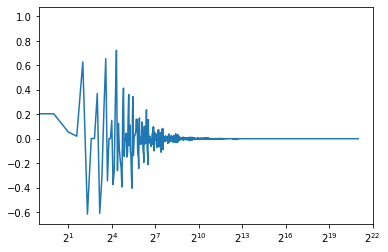

In [232]:
plt.plot(sig_ser)
plt.xscale('log', base = 2)

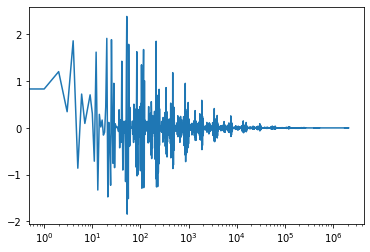

In [53]:
plt.plot(sig_s)
plt.xscale('log')

In [27]:
len(sig_n) # FOR PROCESSES DIV BY 8 IT LOOKS COMPLETELY DIFFERENT...!

2097151

In [59]:
#plt.plot(sig_ser)
plt.axvline(numpy.logspace(0, 25, num = 26, base = 2))
#plt.plot(sig_n)

NameError: name 'numpy' is not defined

In [ ]:
plt.plot(sig_ser)

for i in range (26):
    plt.axvline(2**i)